In [8]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# import custom modules
from dataset_utils import read_annotations, FOLDS, FOLDS_ROOT, IMAGES_ROOT, EXTRACTED_IMAGES_ROOT
from plotting import plot_image_with_bounding_boxes, load_image_to_array

# set the split type and get the folds
# NOTE: you have to run this code for each split type (TRAIN, VAL, TEST)
split_type = "VAL"
folds = FOLDS[split_type]

# read annotations for all images in the given folds
all_annotations_per_image = read_annotations(FOLDS_ROOT, folds)

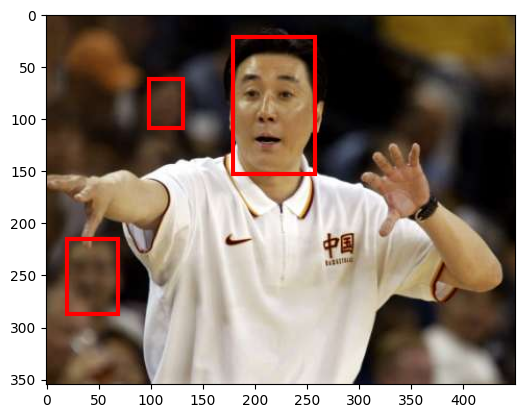

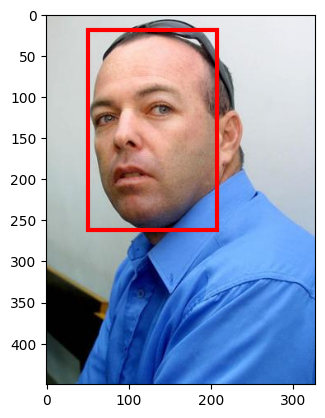

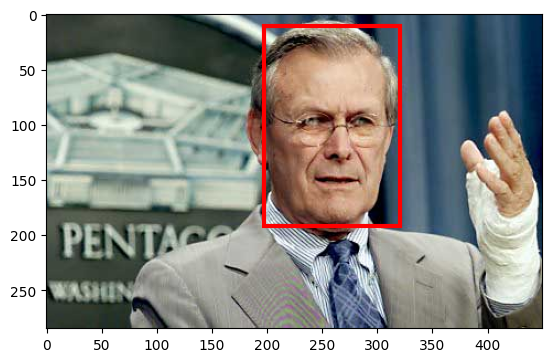

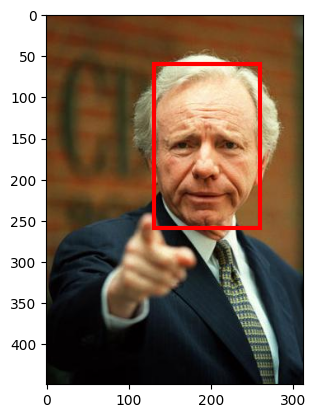

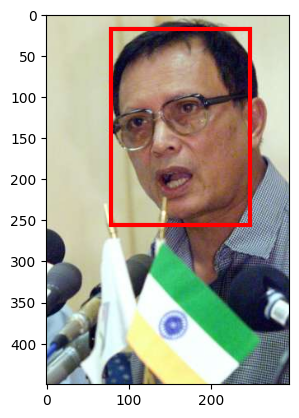

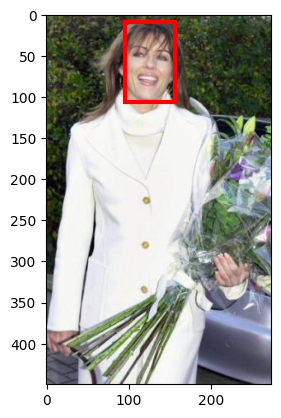

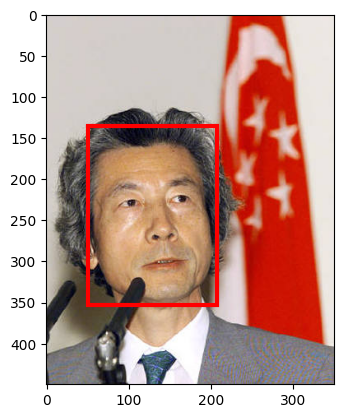

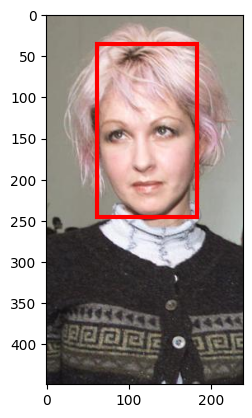

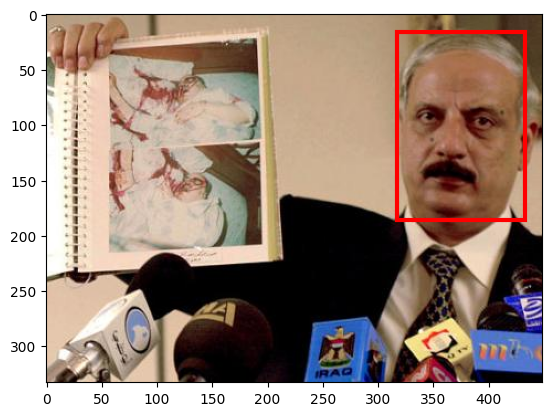

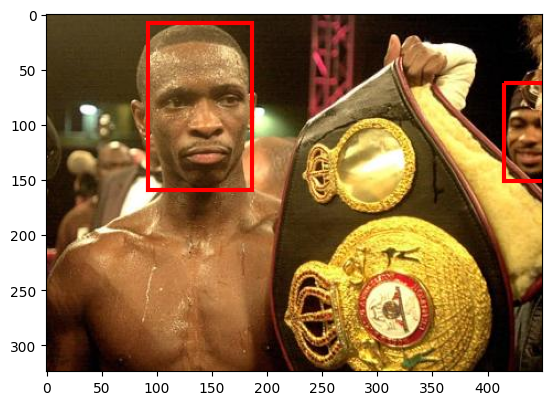

In [9]:
# loop through the first 10 keys in the dictionary of annotations per image
for key in list(all_annotations_per_image.keys())[:10]:

    # get the bounding boxes for the current image
    bboxes = all_annotations_per_image[key]

    # load the image as a numpy array
    img_array = load_image_to_array(IMAGES_ROOT / (key + ".jpg"))

    # plot the image with the bounding boxes
    plot_image_with_bounding_boxes(img_array, bboxes)

Median width:  82.38793075832491
Median height:  123.53471780105096
Median aspect ratio:  1.4948209549118974


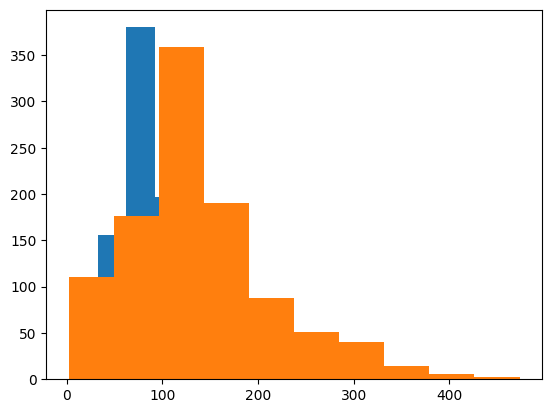

In [10]:
# create empty lists to store the heights and widths of all bounding boxes
all_bbox_widths = []
all_bbox_heights = []

# loop through all annotations for all images
for bboxes in all_annotations_per_image.values():
    for bbox in bboxes:
        # calculate the height and width of the current bounding box and append to the respective lists
        all_bbox_heights.append(bbox[2] - bbox[0])
        all_bbox_widths.append(bbox[3] - bbox[1])

# plot histograms of the widths and heights of all bounding boxes
plt.hist(all_bbox_widths)
plt.hist(all_bbox_heights)

# print the median width, median height, and median aspect ratio of all bounding boxes
print("Median width: ", np.quantile(all_bbox_widths, 0.5))
print("Median height: ", np.quantile(all_bbox_heights, 0.5))
print("Median aspect ratio: ", np.quantile(np.array(all_bbox_heights) / np.array(all_bbox_widths), 0.5))

Aspect ratio makes sense! Extract rectangles of dimension (80, 120) or reshape images to that size before exporting them!

Extract images:

In [11]:
# set the target width and height for the extracted images
target_width = 80
target_height = 120

# set the number of background images to extract per original image
num_background_per_image = 2

# create directories to store the extracted images
(EXTRACTED_IMAGES_ROOT / split_type / "0").mkdir(parents=True, exist_ok=True)
(EXTRACTED_IMAGES_ROOT / split_type / "1").mkdir(parents=True, exist_ok=True)

# create a random number generator with a fixed seed
rng = np.random.default_rng(seed=0)

# define a function to calculate the intersection over union (IoU) of two bounding boxes
def bb_intersection_over_union(boxA, boxB):
    # Function from https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

# define a function to normalize a bounding box to fit within an image
def normalize_box(bbox, image_shape):
     h0, w0, h1, w1 = bbox

     return (max(h0, 0), max(w0, 0), min(h1, image_shape[0]), min(w1, image_shape[1]))

# loop through all images and their annotations
for image_path, annotations_on_image in list(all_annotations_per_image.items()):

    # open the image and convert to a numpy array
    img = Image.open(IMAGES_ROOT / (image_path + ".jpg"))
    img_array = np.asarray(img)

    # extract faces from the image
    for count, bbox in enumerate(annotations_on_image):
        # convert the bounding box to integer values and normalize to fit within the image
        int_bbox = tuple(int(bbox_coord) for bbox_coord in bbox)
        int_bbox = normalize_box(int_bbox, img_array.shape)
        # crop the face image and resize to the target size
        cropped_face_image = Image.fromarray(img_array[int_bbox[0]:int_bbox[2], int_bbox[1]:int_bbox[3]])
        cropped_face_image = cropped_face_image.resize((target_width, target_height), Image.LANCZOS)
        # save the cropped face image
        cropped_face_image.save(EXTRACTED_IMAGES_ROOT / split_type / "1" / (image_path.replace("/", "_") + f"_{count}.jpg"))

    # extract background images from the image
    bg_image_counter = 0
    while bg_image_counter < num_background_per_image:
        # choose a random center point for the background image
        center_height = rng.integers(0, high=img_array.shape[0])
        center_width = rng.integers(0, high=img_array.shape[1])

        # choose random dimensions for the background bounding box
        half_width = rng.integers(20, 60)
        half_height = int(half_width * target_height / target_width)
        
        # compute the bounding box for the background image
        bg_box = (center_height - half_height, center_width - half_width, center_height + half_height, center_width + half_width)

        # check if the bounding box is outside the image boundaries
        if (bg_box[0] < 0) or (bg_box[1] < 0) or (bg_box[2] > img_array.shape[0]) or (bg_box[3] > img_array.shape[1]):
            print("Unsuitable image")
            continue

        # check if the bounding box overlaps too much with any of the face bounding boxes
        if any(bb_intersection_over_union(bg_box, annotation) > 0.1 for annotation in annotations_on_image):
             print("Too large overlap")
             continue

        # crop the background image and resize to the target size
        cropped_bg_image = Image.fromarray(img_array[bg_box[0]:bg_box[2], bg_box[1]:bg_box[3]])
        cropped_bg_image = cropped_bg_image.resize((target_width, target_height), Image.LANCZOS)
        # save the cropped background image
        cropped_bg_image.save(EXTRACTED_IMAGES_ROOT / split_type / "0" / (image_path.replace("/", "_") + f"_{bg_image_counter}.jpg"))
        bg_image_counter += 1
        print("Success")

Unsuitable image
Too large overlap
Unsuitable image
Unsuitable image
Too large overlap
Success
Unsuitable image
Success
Success
Unsuitable image
Success
Unsuitable image
Unsuitable image
Success
Unsuitable image
Too large overlap
Unsuitable image
Too large overlap
Unsuitable image
Unsuitable image
Unsuitable image
Success
Too large overlap
Success
Too large overlap
Unsuitable image
Success
Success
Success
Success
Success
Success
Unsuitable image
Too large overlap
Too large overlap
Success
Success
Unsuitable image
Unsuitable image
Success
Success
Too large overlap
Success
Unsuitable image
Unsuitable image
Unsuitable image
Success
Success
Too large overlap
Unsuitable image
Unsuitable image
Success
Unsuitable image
Too large overlap
Too large overlap
Too large overlap
Unsuitable image
Too large overlap
Unsuitable image
Unsuitable image
Unsuitable image
Unsuitable image
Success
Unsuitable image
Too large overlap
Unsuitable image
Success
Too large overlap
Success
Unsuitable image
Success
To

: 